In [1]:
import NumericalModel
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create a NumericalModel type

model0 = NumericalModel.NumericalModel()

In [3]:
coordVec = np.loadtxt(fname= "../Testing input data/coordVec_plateWithHole.txt")
dx = coordVec[1,0] - coordVec[0,0] 
nodeVolumes = np.full(shape=coordVec.shape[0],fill_value= dx**2)

In [4]:
model0.Geometry.input_part_nodes(inputCoordinates=coordVec,inputVolumes=nodeVolumes)

In [5]:
part_nodes = model0.Geometry.part_nodes.get_part_nodes()

In [ ]:
model0.Geometry.sets.create_node_set()

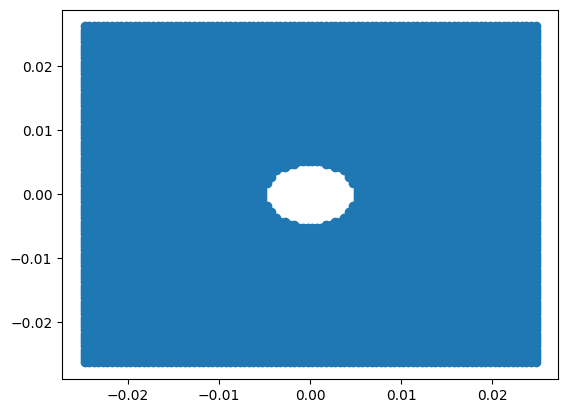

In [6]:
plt.scatter(coordVec[:,0],coordVec[:,1])